<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
%%capture
import itertools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

!pip install imblearn
!pip install delayed
# Install and restart

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-01-04 14:46:46--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-01-04 14:46:47 (179 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


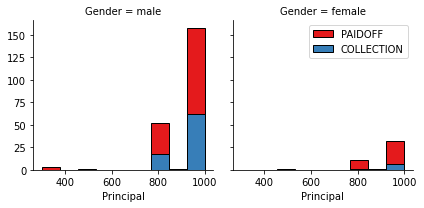

In [7]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

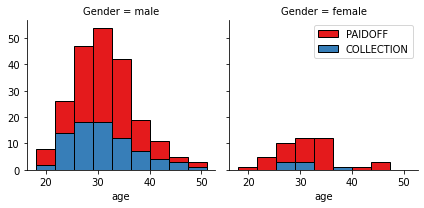

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


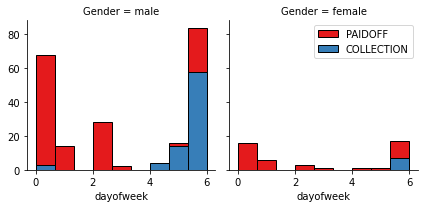

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Encoding Labels

In [18]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y
# 1 : paidoff, 0 : COLLECTION     

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Handle Imbalanced Dataset with SMOTE

In [19]:
oversample = SMOTE()

In [20]:
X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({1: 260, 0: 260})


## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [21]:
# Scaling features

scaler = preprocessing.StandardScaler() # StandardScaler()  RobustScaler()  MinMaxScaler() MaxAbsScaler()
X = scaler.fit_transform(X)
X[0:5]

array([[ 0.48268234,  0.86862188,  2.56566738, -0.34740417, -1.57795212,
        -0.31152273,  1.27006509, -0.77142208],
       [ 0.48268234,  0.86862188,  0.44573035,  2.87849167, -1.57795212,
         3.2100386 , -0.78736122, -0.77142208],
       [ 0.48268234, -1.0589032 , -0.61423817, -0.34740417, -1.57795212,
        -0.31152273, -0.78736122,  1.29630721],
       [ 0.48268234,  0.86862188, -0.43757675,  2.87849167,  0.63373279,
        -0.31152273, -0.78736122,  1.29630721],
       [ 0.48268234,  0.86862188, -0.26091533, -0.34740417,  0.63373279,
        -0.31152273, -0.78736122,  1.29630721]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


## Import Libraries

In [22]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics         import jaccard_score, f1_score, log_loss, accuracy_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# configure the cross-validation procedure
kf = StratifiedKFold(n_splits = 10 , shuffle = True , random_state = 42)

##  Hyperparameter Tuning Function

In [23]:
def tune_hyperparameter(search_method, estimator, search_space):
    
    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in kf.split(X,y):
            
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)

        if search_method == "GridSearch":
            clf = GridSearchCV(
                estimator=estimator, 
                param_grid=search_space, 
                scoring='accuracy',
                n_jobs=-1, 
                cv=cv_inner, 
                verbose=0,
                refit=True
            )
        elif search_method == "RandomSearch":           
            clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=search_space,
                n_iter=10,
                n_jobs=-1,
                cv=cv_inner,
                verbose=0,
                random_state=1,
                refit=True
            )
            
        # execute grid search
        result = clf.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_

        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)

        # evaluate the model
        acc = accuracy_score(y_test, yhat)

        # store the result
        outer_results.append(acc)

        # report progress
        print('acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

    print("Best",search_method,"Model : ", best_model)
    print("-"*50, '\n\n')
    return best_model

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


#### Compare performance on k = [1, 100]

In [24]:
%%time
Ks = 100
mean_acc = []
std_acc = []

for n in range(1,Ks):
    
    train_scores, validation_scores = [], []

    for fold, (tr_index , val_index) in enumerate(kf.split(X , y)): 
        X_train,X_val = X[tr_index] , X[val_index]
        y_train,y_val = y[tr_index] , y[val_index]

        model_knn = KNeighborsClassifier(n_neighbors = n)
        model_knn.fit(X_train,y_train)

        accuracy_score_train = accuracy_score(y_train, model_knn.predict(X_train))
        accuracy_score_validation = accuracy_score(y_val, model_knn.predict(X_val))

        train_scores.append(accuracy_score_train)
        validation_scores.append(accuracy_score_validation)
    print(f'\nk={n}')
    print(f'Mean train score : {np.mean(train_scores)} --- Std train score :{np.std(train_scores)}')
    print(f'Mean validation score : {np.mean(validation_scores)} --- Std validation score :{np.std(validation_scores)}')
    
    mean_acc.append(np.mean(validation_scores))
    std_acc.append(np.std(validation_scores))

print(f'\nOverall Mean Accuracy: {np.mean(mean_acc)}')
print(f'Overall Std Accuracy: {np.mean(std_acc)}')


k=1
Mean train score : 0.7865384615384615 --- Std train score :0.016998934276238293
Mean validation score : 0.6326923076923077 --- Std validation score :0.07761706181004062

k=2
Mean train score : 0.844017094017094 --- Std train score :0.009115696157137405
Mean validation score : 0.7173076923076923 --- Std validation score :0.07549148625534816

k=3
Mean train score : 0.8337606837606837 --- Std train score :0.006743475999170735
Mean validation score : 0.7442307692307693 --- Std validation score :0.07094564132960274

k=4
Mean train score : 0.844017094017094 --- Std train score :0.01122557738167837
Mean validation score : 0.7615384615384616 --- Std validation score :0.06213651700539812

k=5
Mean train score : 0.8418803418803418 --- Std train score :0.011346938502010028
Mean validation score : 0.7692307692307694 --- Std validation score :0.057692307692307696

k=6
Mean train score : 0.8371794871794871 --- Std train score :0.008851416742396569
Mean validation score : 0.7807692307692309 --- 

### KNN Models Accuracy Plot



Maximum accuracy:- 0.7807692307692309 at K = 6


Text(0, 0.5, 'Accuracy')

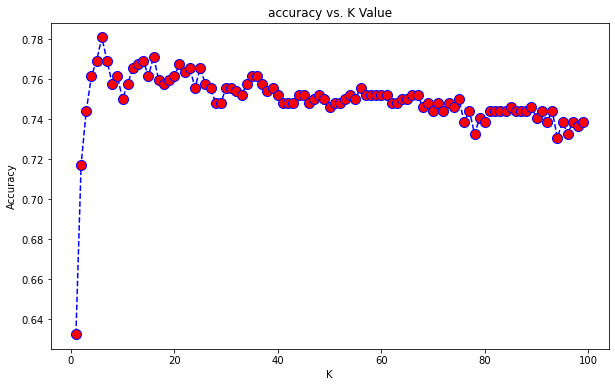

In [25]:
print("\n\nMaximum accuracy:-",max(mean_acc),"at K =",mean_acc.index(max(mean_acc))+1)

plt.figure(figsize=(10,6))
plt.plot(range(1,100),mean_acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

## KNN Classifier with Best k value

In [26]:
%%time

train_scores, validation_scores = [], []

for fold, (tr_index , val_index) in enumerate(kf.split(X , y)): 
    X_train,X_val = X[tr_index] , X[val_index]
    y_train,y_val = y[tr_index] , y[val_index]

    model_knn_6 = KNeighborsClassifier(n_neighbors = 6)
    model_knn_6.fit(X_train,y_train)

    accuracy_score_train = accuracy_score(y_train, model_knn_6.predict(X_train))
    accuracy_score_validation = accuracy_score(y_val, model_knn_6.predict(X_val))

    train_scores.append(accuracy_score_train)
    validation_scores.append(accuracy_score_validation)

print(f'Mean train score : {np.mean(train_scores)} --- Std train score :{np.std(train_scores)}')
print(f'Mean validation score : {np.mean(validation_scores)} --- Std validation score :{np.std(validation_scores)}')


Mean train score : 0.8371794871794871 --- Std train score :0.008851416742396569
Mean validation score : 0.7807692307692309 --- Std validation score :0.07457969011409737
CPU times: user 229 ms, sys: 10 µs, total: 229 ms
Wall time: 227 ms


## Extended Hyperparameter Tuning KNN

In [27]:
%%time

knn_model = KNeighborsClassifier()

knn_params_grid = {
#     "n_neighbors": [i for i in range(1,30)],
    "n_neighbors": [6],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1, 10, 30],
    "p": [1,2]
}

knn_params_random = {
    "n_neighbors": [6],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": scipy.stats.randint(1,1000),
    "p": [1,2]
}

best_knn_grid_searched_model = tune_hyperparameter('GridSearch', knn_model, knn_params_grid)
best_knn_randomized_searched_model = tune_hyperparameter('RandomSearch', knn_model, knn_params_random)

acc=0.731, est=0.821, cfg={'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
acc=0.788, est=0.788, cfg={'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
acc=0.769, est=0.808, cfg={'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
acc=0.692, est=0.816, cfg={'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
acc=0.769, est=0.814, cfg={'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
acc=0.788, est=0.791, cfg={'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
acc=0.750, est=0.806, cfg={'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
acc=0.923, est=0.780, cfg={'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
acc=0.827, est=0.808, cfg={'algorithm': 'brute', 'leaf_siz

# Decision Tree


### Modeling

In [28]:
%%time

train_scores, validation_scores = [], []

for fold, (tr_index , val_index) in enumerate(kf.split(X , y)): 
    X_train,X_val = X[tr_index] , X[val_index]
    y_train,y_val = y[tr_index] , y[val_index]

    model_decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
    model_decision_tree.fit(X_train,y_train)

    accuracy_score_train = accuracy_score(y_train, model_decision_tree.predict(X_train))
    accuracy_score_validation = accuracy_score(y_val, model_decision_tree.predict(X_val))

    train_scores.append(accuracy_score_train)
    validation_scores.append(accuracy_score_validation)

print(f'Mean train score : {np.mean(train_scores)} --- Std train score :{np.std(train_scores)}')
print(f'Mean validation score : {np.mean(validation_scores)} --- Std validation score :{np.std(validation_scores)}')


Mean train score : 0.8314102564102563 --- Std train score :0.010660230498518311
Mean validation score : 0.7923076923076922 --- Std validation score :0.03922322702763681
CPU times: user 19.4 ms, sys: 102 µs, total: 19.5 ms
Wall time: 19.8 ms


## Hyperparameter Tuning Decision Tree

In [29]:
%%time

dtree_model = DecisionTreeClassifier(random_state=42)

dtree_params = {
    'max_depth': [2, 3, 5, 6, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# dtc_param = {
#     "max_depth": [None],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "min_weight_fraction_leaf": [0.],
#     "max_features": [None],
#     "random_state": [4],
#     "max_leaf_nodes": [None], # None = infinity or int
#     "presort": [True, False]
# }

best_dtree_grid_searched_model = tune_hyperparameter('GridSearch', dtree_model, dtree_params)
best_dtree_randomized_searched_model = tune_hyperparameter('RandomSearch', dtree_model, dtree_params)

acc=0.692, est=0.795, cfg={'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}
acc=0.827, est=0.761, cfg={'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5}
acc=0.827, est=0.774, cfg={'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5}
acc=0.750, est=0.786, cfg={'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5}
acc=0.692, est=0.771, cfg={'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5}
acc=0.731, est=0.769, cfg={'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5}
acc=0.827, est=0.767, cfg={'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5}
acc=0.750, est=0.752, cfg={'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}
acc=0.769, est=0.757, cfg={'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
acc=0.846, est=0.795, cfg={'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}
Accuracy: 0.771 (0.055)
Best GridSearch Model :  DecisionTreeClassifier(max_depth=10, min_samples_leaf

# Support Vector Machine


### Modeling

In [30]:
%%time
train_scores, validation_scores = [], []

for fold, (tr_index , val_index) in enumerate(kf.split(X , y)): 
    X_train,X_val = X[tr_index] , X[val_index]
    y_train,y_val = y[tr_index] , y[val_index]

    model_svm = svm.SVC(kernel='linear')
    model_svm.fit(X_train,y_train)

    accuracy_score_train = accuracy_score(y_train, model_svm.predict(X_train))
    accuracy_score_validation = accuracy_score(y_val, model_svm.predict(X_val))

    train_scores.append(accuracy_score_train)
    validation_scores.append(accuracy_score_validation)

print(f'Mean train score : {np.mean(train_scores)} --- Std train score :{np.std(train_scores)}')
print(f'Mean validation score : {np.mean(validation_scores)} --- Std validation score :{np.std(validation_scores)}')

Mean train score : 0.775 --- Std train score :0.0054935727060608525
Mean validation score : 0.775 --- Std validation score :0.04944215435454783
CPU times: user 91.6 ms, sys: 0 ns, total: 91.6 ms
Wall time: 91.6 ms


## Hyperparameter Tuning SVM

In [31]:
%%time
svm_model = svm.SVC(random_state=42)

svm_param_grid = {
    'C': [0.1, 1, 10, 100, 100], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear','rbf', 'poly', 'sigmoid']
}

svm_param_random = {
    "C": scipy.stats.expon(scale=.01),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ['linear','rbf', 'poly', 'sigmoid']
}

best_svm_grid_searched_model = tune_hyperparameter('GridSearch', svm_model, svm_param_grid)
best_svm_randomized_searched_model = tune_hyperparameter('RandomSearch', svm_model, svm_param_random)

acc=0.712, est=0.819, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.827, est=0.788, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.788, est=0.799, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.712, est=0.801, cfg={'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
acc=0.654, est=0.791, cfg={'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
acc=0.808, est=0.793, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.827, est=0.786, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.942, est=0.784, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.808, est=0.801, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
acc=0.846, est=0.784, cfg={'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.792 (0.078)
Best GridSearch Model :  SVC(C=1, gamma=1, random_state=42)
-------------------------------------------------- 


acc=0.712, est=0.748, cfg={'C': 0.011078933350566445, 'gamma': 0.02741695987651143, 'kernel': 'linear'}
acc=0.788, est=0.741, cfg={'C': 0.011078933350566445, 'gamma': 0.02741695987651143, 'kernel': 'linear'}
acc=

# Logistic Regression


### Modeling

In [32]:
%%time
train_scores, validation_scores = [], []

for fold, (tr_index , val_index) in enumerate(kf.split(X , y)): 
    X_train,X_val = X[tr_index] , X[val_index]
    y_train,y_val = y[tr_index] , y[val_index]

    model_LR = LogisticRegression(C=0.01, solver='liblinear')
    model_LR.fit(X_train,y_train)

    accuracy_score_train = accuracy_score(y_train, model_LR.predict(X_train))
    accuracy_score_validation = accuracy_score(y_val, model_LR.predict(X_val))

    train_scores.append(accuracy_score_train)
    validation_scores.append(accuracy_score_validation)

print(f'Mean train score : {np.mean(train_scores)} --- Std train score :{np.std(train_scores)}')
print(f'Mean validation score : {np.mean(validation_scores)} --- Std validation score :{np.std(validation_scores)}')

Mean train score : 0.764102564102564 --- Std train score :0.005588331978898325
Mean validation score : 0.7653846153846153 --- Std validation score :0.052171769100963605
CPU times: user 21.2 ms, sys: 28 µs, total: 21.2 ms
Wall time: 24.7 ms


## Hyperparameter Tuning Logistic Regression

In [33]:
%%time
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {'C': [0.01, 0.1, 10, 100],
 'fit_intercept': [True, False],
 'warm_start': [True, False],
 'random_state': [42]
}

lr_param_random = {'C': scipy.stats.expon(scale=.01),
 'fit_intercept': [True, False],
 'warm_start': [True, False],
 'random_state': [42]
}

best_lr_grid_searched_model = tune_hyperparameter('GridSearch', lr_model, lr_param_grid)
best_lr_randomized_searched_lr_model = tune_hyperparameter('RandomSearch', lr_model, lr_param_random)

acc=0.769, est=0.774, cfg={'C': 0.1, 'fit_intercept': True, 'random_state': 42, 'warm_start': True}
acc=0.808, est=0.765, cfg={'C': 100, 'fit_intercept': False, 'random_state': 42, 'warm_start': True}
acc=0.731, est=0.774, cfg={'C': 10, 'fit_intercept': False, 'random_state': 42, 'warm_start': True}
acc=0.808, est=0.756, cfg={'C': 0.1, 'fit_intercept': False, 'random_state': 42, 'warm_start': True}
acc=0.712, est=0.795, cfg={'C': 10, 'fit_intercept': True, 'random_state': 42, 'warm_start': True}
acc=0.712, est=0.786, cfg={'C': 10, 'fit_intercept': True, 'random_state': 42, 'warm_start': True}
acc=0.750, est=0.767, cfg={'C': 0.01, 'fit_intercept': False, 'random_state': 42, 'warm_start': True}
acc=0.827, est=0.769, cfg={'C': 100, 'fit_intercept': False, 'random_state': 42, 'warm_start': True}
acc=0.808, est=0.778, cfg={'C': 10, 'fit_intercept': False, 'random_state': 42, 'warm_start': True}
acc=0.769, est=0.761, cfg={'C': 10, 'fit_intercept': True, 'random_state': 42, 'warm_start': True

# Model Evaluation using Test set


First, download and load the test set:


In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-01-04 15:03:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-01-04 15:03:42 (96.9 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


## Preprocessing Test Dataset

In [36]:
X_test = test_df
X_test[0:5]

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [37]:
## Preprocessing
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

# X_test = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
X_test = scaler.transform(test_Feature) # StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
X_test[0:5]

array([[ 0.48268234,  0.86862188,  3.44897448,  2.87849167, -1.57795212,
         3.2100386 , -0.78736122, -0.77142208],
       [-6.57339679, -2.08691657,  0.79905319, -0.34740417,  0.63373279,
        -0.31152273, -0.78736122, -0.77142208],
       [ 0.48268234,  0.86862188,  2.21234455,  2.87849167,  0.63373279,
        -0.31152273,  1.27006509, -0.77142208],
       [ 0.48268234,  0.86862188, -0.79089959, -0.34740417,  0.63373279,
        -0.31152273, -0.78736122,  1.29630721],
       [-1.53334027, -1.0589032 , -0.26091533, -0.34740417,  0.63373279,
         3.2100386 , -0.78736122, -0.77142208]])

In [38]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [39]:
# Label Encoding

y_test = le.fit_transform(y_test)
y_test

# 1 : paidoff, 0 : COLLECTION 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
test_df.loan_status.value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [41]:
# Init reporting DataFrame
score_report_df = pd.DataFrame(columns=['Algorithm','Jaccard','F1-score','LogLoss'])

In [42]:
# Final score of kNN
yhat_knn_6 = model_knn_6.predict(X_test)
print(f"KNN model with 6 neighbors: jaccard_score : {jaccard_score(y_test, yhat_knn_6):.3f} , f1_score : {f1_score(y_test, yhat_knn_6):.3f}")


yhat_best_knn_model = best_knn_grid_searched_model.predict(X_test)
print(f"KNN model with 6 neighbors tuned: jaccard_score : {jaccard_score(y_test, yhat_best_knn_model):.3f} , f1_score : {f1_score(y_test, yhat_best_knn_model):.3f}")

score_report_df.loc[0] =['KNN','{0:.3f}'.format(jaccard_score(y_test, yhat_best_knn_model)), '{0:.3f}'.format(f1_score(y_test, yhat_best_knn_model)), 'NA' ]

KNN model with 6 neighbors: jaccard_score : 0.625 , f1_score : 0.769
KNN model with 6 neighbors tuned: jaccard_score : 0.638 , f1_score : 0.779


In [43]:
# Final score of Decision Tree
yhat_dtree = best_dtree_grid_searched_model.predict(X_test)
print(f"Decision Tree model tuned: jaccard_score : {jaccard_score(y_test, yhat_dtree):.3f} , f1_score : {f1_score(y_test, yhat_dtree):.3f}")

score_report_df.loc[1] =['Decision Tree','{0:.3f}'.format(jaccard_score(y_test, yhat_dtree)), '{0:.3f}'.format(f1_score(y_test, yhat_dtree)), 'NA' ]

Decision Tree model tuned: jaccard_score : 0.660 , f1_score : 0.795


In [44]:
# # Final score of SVM
yhat_svm = best_svm_grid_searched_model.predict(X_test)
print(f"SVM model tuned: jaccard_score : {jaccard_score(y_test, yhat_svm):.3f} , f1_score : {f1_score(y_test, yhat_svm):.3f}")

score_report_df.loc[2] =['SVM','{0:.3f}'.format(jaccard_score(y_test, yhat_svm)), '{0:.3f}'.format(f1_score(y_test, yhat_svm)), 'NA' ]

SVM model tuned: jaccard_score : 0.708 , f1_score : 0.829


In [45]:
# Final score of Logistic Regression

yhat_lr = best_lr_grid_searched_model.predict(X_test)
yhat_lr_prob = best_lr_grid_searched_model.predict_proba(X_test)
print(f"Logistic Regression model tuned: jaccard_score : {jaccard_score(y_test, yhat_lr):.3f} , f1_score : {f1_score(y_test, yhat_lr):.3f}, log_loss : {log_loss(y_test, yhat_lr_prob):.3f}")

score_report_df.loc[3] =['LogisticRegression','{0:.3f}'.format(jaccard_score(y_test, yhat_lr)), '{0:.3f}'.format(f1_score(y_test, yhat_lr)), '{0:.3f}'.format(log_loss(y_test, yhat_lr_prob)) ]

Logistic Regression model tuned: jaccard_score : 0.583 , f1_score : 0.737, log_loss : 0.543


## Model Comparison Report

In [46]:
score_report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.638,0.779,NA
1,Decision Tree,0.660,0.795,NA
2,SVM,0.708,0.829,NA
3,LogisticRegression,0.583,0.737,0.543


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
